In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import emcee as mc
from scipy.optimize import curve_fit
from corner import corner
from IPython.display import display, Math

from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
from astropy.visualization import quantity_support
from astropy.modeling.models import BlackBody

quantity_support()
set_matplotlib_formats('svg')
from matplotlib import cm
from cycler import cycler
plt.rc('legend', frameon = False)
plt.rc('figure', figsize = (7, 7/1.25))
plt.rc('font', size = 14)

In [4]:
#get the data
names = ["freq", "monopole", "res", "sigma", "gal"]
tmp = pd.read_csv("https://lambda.gsfc.nasa.gov/data/cobe/firas/monopole_spec/firas_monopole_spec_v1.txt", delim_whitespace = True, header = 0, skiprows = 17, names = names)
unit_names = ["cm-1", "MJy/sr", "kJy/sr", "kJy/sr", "kJy/sr"]
units = {names[i]:unit_names[i] for i in range(len(names))}
firas = QTable.from_pandas(tmp, units = units)

#make a version of the frequency in GHz
firas_freq = firas["freq"].to('GHz', equivalencies = u.spectral())

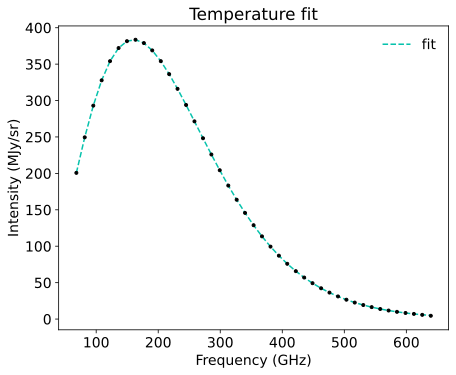

In [6]:
bb_simple = BlackBody(2.725*u.K)
plt.figure()
plt.errorbar(firas_freq, firas["monopole"], yerr = firas["sigma"], fmt = 'k.')
plt.plot(firas_freq, bb_simple(firas_freq).to('MJy/sr'), color = 'xkcd:turquoise', ls = "--", label = "fit")
plt.xlabel("Frequency (GHz)")
plt.ylabel("Intensity (MJy/sr)")
plt.title("Monopole temperature")
plt.legend();

Part 1: reproduce the monopole temperature fit using emcee

In [19]:
#log likelihood function:
def log_LBB(T, nu, S, Serr):
    #T is temperature in Kelvin
    #nu is frequency in s-1
    #S is the monopole spectrum in MJy/sr
    #and Serr is the error in kJy/sr
    
    x = const.h*nu/const.k_B/T
    model = (2*const.h*nu**3/const.c**2 * 1/np.expm1(x)).to('MJy')/u.sr
    
    log_L = -0.5 * np.sum((S-model)**2/Serr**2)
    return log_L

In [21]:
#run mcmc
np.random.seed(42)
chain_len = 5000
T_ini = 2.725*u.K
pos = T_ini + 1e-6*np.random.randn(32, 1)*u.K
nwalkers, ndim = pos.shape

sampler = mc.EnsembleSampler(nwalkers, ndim, log_LBB, args = (firas_freq.to('s-1'), firas["monopole"], firas["sigma"]))
sampler.run_mcmc(pos, chain_len, progress = True);

100%|███████████████████████████████████████| 5000/5000 [02:03<00:00, 40.59it/s]


In [22]:
#get autocorrelation time:
tau = sampler.get_autocorr_time()
print(tau)

#get all samples:
samples = sampler.get_chain()
print(samples.shape)

#plot samples over time
plt.figure()
plt.plot(samples[:, :, 0], "k", alpha = 0.3)
plt.ylabel("T")
plt.xlabel("sample number");

[27.31138775]
(5000, 32, 1)


In [23]:
#print final estimate
flat_samples = sampler.get_chain(discard = 5*int(tau), thin = int(tau), flat = True)
T_mcmc = np.percentile(flat_samples[:, 0], [16, 50, 84])
q = np.diff(T_mcmc)

txt = "\mathrm{{{3}}} = {0:.6f}_{{-{1:.6f}}}^{{{2:.6f}}}"
txt = txt.format(T_mcmc[1], q[0], q[1], "T")
display(Math(txt))

<IPython.core.display.Math object>

Part 2: sample $\mu$ and $y$

In [24]:
def dBdT(nu, T = 2.725*u.K):
    #nu is frequency in s-1
    x = const.h*nu/const.k_B/T
    return 2 * const.h**2 * nu**4 / (const.k_B * const.c**2 * T**2) * np.exp(x) / np.expm1(x)**2

def func_mu(nu, mu):
    #nu is frequency in s-1
    #mu is dimensionless
    
    T = 2.725*u.K
    x = const.h*nu/const.k_B/T
    #return (-T*mu/x * dBdT(nu)).to('kJy')/u.sr
    
    I_0 = 270*u.MJy
    beta = 2.1923
    return -(I_0 * x**4 * np.exp(x)/np.expm1(x)**2 * (1/beta - 1/x) * mu).to('kJy')/u.sr

def func_y(nu, y):
    #nu is frequency in s-1
    #y is dimensionless
    T = 2.725*u.K
    x = const.h*nu/const.k_B/T
    
    #note: typo in F96, compare to Bianchini & Fabbian 2022
    return (y *T*(x*(np.exp(x)+1)/np.expm1(x) - 4)*dBdT(nu)).to('kJy')/u.sr

In [25]:
def log_Ly(theta, nu, Sres, Serr):
    #nu is an array of frequencies in s-1
    #Sres and Serr are the residual and error arrays in kJy/sr
    T, y = theta
    model = func_y(nu, y)
    
    log_L = -0.5 * np.sum((Sres-model)**2/Serr**2)
    return log_L

def log_Lmu(theta, nu, Sres, Serr):
    T, mu = theta
    model = func_mu(nu, mu)/u.sr*u.kJy
    
    log_L = -0.5 * np.sum((Sres-model)**2/Serr**2)
    return log_L